In [1]:
import numpy as np
import time
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
import matplotlib.dates as dates

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, ParameterGrid, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score 

import tensorflow as tf
from keras.layers import Dropout, Dense, LSTM
from keras.models import Sequential
import keras.losses

gpu_fraction = 0.9
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

print('done')

done


Using TensorFlow backend.


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.mixture import GaussianMixture

In [4]:
df_T1 = pd.read_csv('T1.csv.gz', compression="gzip")
df_T2 = pd.read_csv('T2.csv.gz', compression="gzip")
df_T3 = pd.read_csv('T3.csv.gz', compression="gzip")
df_T4 = pd.read_csv('T4.csv.gz', compression="gzip")
df_T5 = pd.read_csv('T5.csv.gz', compression="gzip")

print('done')

done


In [5]:
# default window: 1440 #2 month window: 24*30*2    
def flag_anomalies(flag, predictions, sigma_fault = 2.0, window = 1440):     
    mean = predictions.rolling(window=window,center=False).mean()
    std = predictions.rolling(window=window,center=False).std()
    sel = (predictions>mean+sigma_fault*std) | (predictions<mean-sigma_fault*std)
    flag[sel] = 1
    return flag

In [6]:
def pre_process_data(df, sigma_fault=2.):  
    asset_id = df['asset_id'][0]     
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    #drop entire rows if there is a nan in the target column
    df_clean = df.dropna(subset=['generator___temperature']).copy()
    #df_clean.drop(['met_sensors___temperature___ambient'], axis=1, inplace=True)
    #we have temperatures on a coarser time series so we'll just forward fill
    df_clean['met_sensors___temperature___ambient'].fillna(method='ffill', inplace=True)
    
    #replace nan with mean of the column for numeric variables
    numeric_cols = df_clean.columns[df_clean.dtypes=='float64']
    df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].mean())
  
    #resample into 60min time window     
    df_clean.set_index('timestamp',inplace=True)
    df_clean = df_clean.resample("60Min").mean().bfill()
    df_clean.reset_index(inplace=True)
    #we need to re-assign asset_id since it is an object and has no mean
    df_clean['asset_id'] = asset_id

    #flag abnormal behaviour
    window = 1440 #2 month window: 24*30*2      
    df_clean['flag'] = 0  
    df_clean['flag'] = flag_anomalies(df_clean['flag'].copy(), df_clean['generator___temperature'], 
                                      sigma_fault=2., window=window)    
    return df_clean[window:]

In [7]:
df_clean_1 = pre_process_data(df_T1, sigma_fault=2.)    
df_clean_2 = pre_process_data(df_T2, sigma_fault=2.)    
df_clean_3 = pre_process_data(df_T3, sigma_fault=2.)    
df_clean_4 = pre_process_data(df_T4, sigma_fault=2.)    
df_clean_5 = pre_process_data(df_T5, sigma_fault=2.)  

print('files processed ')

files processed 


In [8]:
def train_test_split_with_scaler(to_keep, df_train, df_test):    
    X_train = df_train[to_keep]
    y_train = df_train['flag']

    X_test = df_test[to_keep]
    y_test = df_test['flag']   

    #data seems to have been scaled so probably not needed
    scaler = StandardScaler()
    scaler.fit(X_train)
    StandardScaler(copy=True, with_mean=True, with_std=True)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    print('done')
    return (X_train, y_train, X_test, y_test)

In [21]:
df_train = pd.concat([df_clean_1, df_clean_2, df_clean_3, df_clean_4])
df_test = df_clean_5.copy()

print(df_train.info(null_counts=True))
print('files processed')

to_keep = ['generator___mechanical___speed', 
           'turbine_data___electrical___power_production',
           'met_sensors___mechanical___wind_speed']
(X_train, y_train, X_test, y_test) = train_test_split_with_scaler(to_keep, df_train, df_test)   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28800 entries, 1440 to 8639
Data columns (total 8 columns):
timestamp                                       28800 non-null datetime64[ns]
generator___mechanical___speed                  28800 non-null float64
generator___temperature                         28800 non-null float64
turbine_data___electrical___power_production    28800 non-null float64
met_sensors___mechanical___wind_speed           28800 non-null float64
met_sensors___temperature___ambient             28800 non-null float64
asset_id                                        28800 non-null object
flag                                            28800 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 2.0+ MB
None
files processed
done


In [27]:
best_model = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'auto', 
              'max_depth': 30, 'criterion': 'mse'}
model = RandomForestRegressor(n_jobs=1, random_state=42)
model.set_params(**best_model)  

model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

print('done')

done


In [10]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data   
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax       

def plot_predicted_abnormal_behaviour(df_test):

    fig, ax = plt.subplots()

    sel = df_test['timestamp']>'2013-05-1' 
    ax.plot(df_test.loc[sel,'timestamp'], df_test.loc[sel,'generator___temperature'], color='green', 
            label='tmp')


    sel = (df_test['pred_flag']==1) & (df_test['timestamp']>'2013-05-1' )
    ax.scatter(df_test.loc[sel,'timestamp'], df_test.loc[sel,'generator___temperature'],color='red', 
               label='predicted anomaly')

    ax.set_xlabel('time'), ax.set_ylabel('Generator Temperature')

    ax.tick_params(left=False, right=False, top=False, bottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    
def print_model_result(y_true, y_predicted):    
    print(f"Roc_Auc: {roc_auc_score(y_true, y_predicted):0.3f}\n")
    print('Classifcation report:\n', classification_report(y_true, y_predicted))

    class_names = np.array(['Non-Faulty', 'Faulty'])
    plot_confusion_matrix(y_true, y_predicted, classes=class_names)
    plt.show()

<br>

# 1 - Classification of Anomalies with K-means Clustering

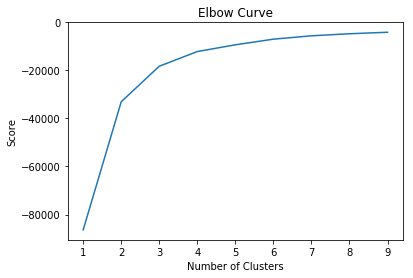

In [12]:
clustno = range(1, 10)

kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]
score = [kmeans[i].fit(X_train).score(X_train) for i in range(len(kmeans))]

plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Roc_Auc: 0.597

Classifcation report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      6485
           1       0.21      0.32      0.26       715

   micro avg       0.82      0.82      0.82      7200
   macro avg       0.57      0.60      0.58      7200
weighted avg       0.85      0.82      0.83      7200

Confusion matrix, without normalization


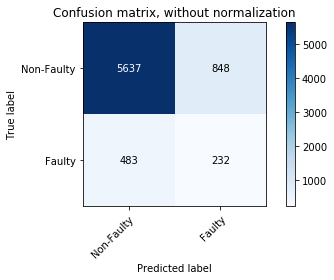

/home/brunohe/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


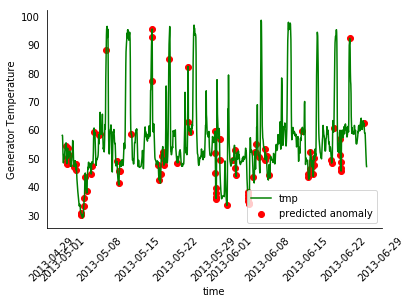

In [13]:
kmeans = KMeans(n_clusters=6, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
test_predictions = np.array(dist)
test_predictions[dist >= np.percentile(dist, 85)] = 1
test_predictions[dist < np.percentile(dist, 85)] = 0

print_model_result(y_test, test_predictions)

df_test['pred_flag'] = test_predictions
plot_predicted_abnormal_behaviour(df_test)

<br>

# 2 - Classification of Anomalies with Gaussian Mixture Models

In [14]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

def plot_results(X, Y_, means, covariances, title, ax): 
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    #plt.xlim(-9., 5.)
    #plt.ylim(-3., 6.)
    #plt.xticks(())
    #plt.yticks(())
    plt.title(title)

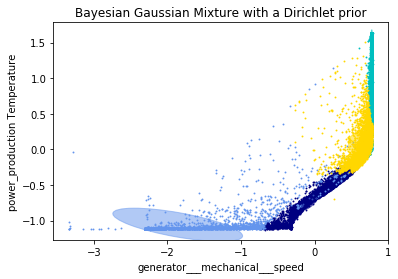

In [15]:
# Fit a Gaussian mixture with EM using five components
#gmm = GaussianMixture(n_components=4, covariance_type='full').fit(X)
#fig, ax = plt.subplots()
#plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 'Gaussian Mixture', ax)
#plt.show()

dpgmm = mixture.BayesianGaussianMixture(n_components=4,
                                        covariance_type='full').fit(X_train)
fig, ax = plt.subplots()
plot_results(X_train, dpgmm.predict(X_train), dpgmm.means_, dpgmm.covariances_, 
             'Bayesian Gaussian Mixture with a Dirichlet prior', ax)
ax.set_xlabel('generator___mechanical___speed')
ax.set_ylabel('power_production Temperature')
plt.show()

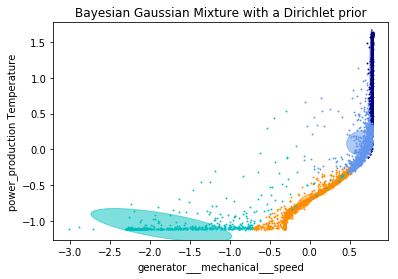

In [16]:
fig, ax = plt.subplots()
plot_results(X_test, dpgmm.predict(X_test), dpgmm.means_, dpgmm.covariances_, 
             'Bayesian Gaussian Mixture with a Dirichlet prior', ax)
ax.set_xlabel('generator___mechanical___speed')
ax.set_ylabel('power_production Temperature')
plt.show()

In [17]:
pred_labels = dpgmm.predict(X_test)
counts = np.bincount(pred_labels[pred_labels>=0])
print(counts)

# Sort the sample counts of the clusters and take the smallest clusters
smallest_clusters = np.argsort(counts)[0]

print("The smallest cluster is:")      
print(smallest_clusters)

print("Its counts are:")      
print(counts[smallest_clusters])

[2365 2410 1507  918]
The smallest cluster is:
3
Its counts are:
918


Roc_Auc: 0.496

Classifcation report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89      6485
           1       0.09      0.12      0.11       715

   micro avg       0.80      0.80      0.80      7200
   macro avg       0.50      0.50      0.50      7200
weighted avg       0.82      0.80      0.81      7200

Confusion matrix, without normalization


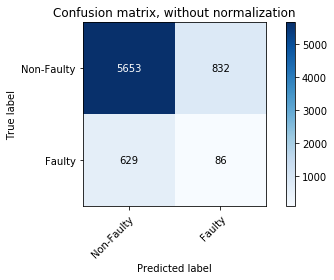

In [18]:
test_predictions = np.zeros(len(y_test))
test_predictions[pred_labels==smallest_clusters] = 1
    
print_model_result(y_test, test_predictions)

## 7.3 - Isolation forest

In [19]:
from sklearn.ensemble import IsolationForest

Roc_Auc: 0.588

Classifcation report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      6485
           1       0.22      0.29      0.25       715

   micro avg       0.83      0.83      0.83      7200
   macro avg       0.57      0.59      0.57      7200
weighted avg       0.85      0.83      0.84      7200

Confusion matrix, without normalization


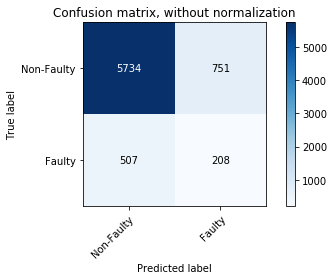

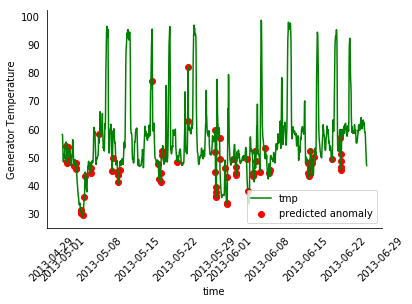

In [20]:
clf=IsolationForest(n_estimators=300, max_samples='auto', contamination=float(.1), max_features=1.0, 
                    bootstrap=False, n_jobs=-1, random_state=42, verbose=0, behaviour="new")

clf.fit(X_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
test_predictions[test_predictions==1] = 0
test_predictions[test_predictions==-1] = 1
print_model_result(y_test, test_predictions)

df_test['pred_flag'] = test_predictions
plot_predicted_abnormal_behaviour(df_test)